In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = "1"

In [2]:
%load_ext autoreload
%autoreload 2

## Create DATASET

### 1 - Generate mask instances

In [3]:
from data_utils import generate_annotations_json

In [4]:
dataset_path = '/root/data/erko/'
mask_dir = 'instance_labels'
frame_dir = 'labeled_frames'
dataset_name = 'fish_only'
class_ID_path = '/root/data/erko/class_ID.csv'

In [5]:
#d_train, d_test = generate_annotations_json(dataset_path=dataset_path,
#                          mask_dir=mask_dir,
#                          frame_dir=frame_dir,
#                          dataset_name=dataset_name,
#                          class_ID_path=class_ID_path,
#                        )

### 2 - Create folder structure

In [6]:
from data_utils import create_training_folder_structure

In [7]:
train_json = 'instance_fish_only_train.json'
test_json = 'instance_fish_only_test.json'
train_target_dir = 'instance_train_images'
test_target_dir = 'instance_test_images'


In [8]:
#create_training_folder_structure(dataset_path=dataset_path,
#                                 train_json=train_json,
#                                 test_json=test_json,
#                                 train_target_dir=train_target_dir,
#                                 test_target_dir=test_target_dir, 
#                                 frame_dir=frame_dir)

### 3 - Datasets

In [9]:
import os
import sys
import random
import math
import re
import time
import numpy as np
import cv2
import matplotlib
import matplotlib.pyplot as plt

sys.path.insert(0, '../libraries')
from mrcnn.config import Config
import mrcnn.utils as utils
import mrcnn.model as modellib
import mrcnn.visualize as visualize
from mrcnn.model import log
import mcoco.coco as coco
import mextra.utils as extra_utils
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

%matplotlib inline
%config IPCompleter.greedy=True
BASE_DIR = '/root/data/models/erko/mask_rcnn_instance_segmentation'
DATA_DIR = '/root/data/erko/'
WEIGHTS_DIR = os.path.join(BASE_DIR, "weights")
MODEL_DIR = os.path.join(BASE_DIR, "logs")

# Local path to trained weights file
COCO_MODEL_PATH = os.path.join(WEIGHTS_DIR, "mask_rcnn_coco.h5")
# Download COCO trained weights from Releases if needed
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)

Using TensorFlow backend.


In [10]:
def get_ax(rows=1, cols=1, size=8):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Change the default size attribute to control the size
    of rendered images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

In [11]:
dataset_name = 'fish_only'

In [12]:
dataset_train  = coco.CocoDataset()
dataset_train.load_coco(dataset_dir=DATA_DIR,
                        dataset_name=dataset_name,
                        subset='train')
dataset_train.prepare()
dataset_validate = coco.CocoDataset()
dataset_validate.load_coco(dataset_dir=DATA_DIR,
                           dataset_name=dataset_name,
                           subset='test')
dataset_validate.prepare()

loading annotations into memory...
Done (t=0.30s)
creating index...
index created!
loading annotations into memory...
Done (t=0.05s)
creating index...
index created!


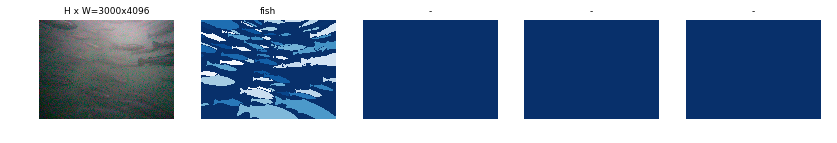

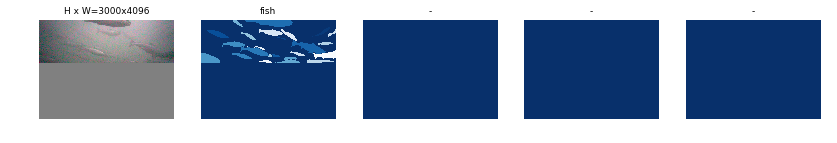

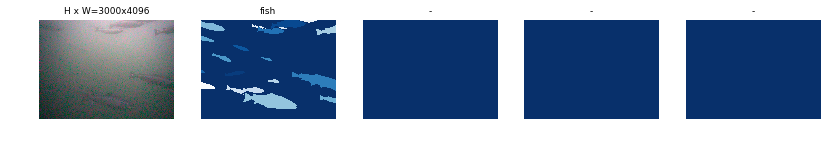

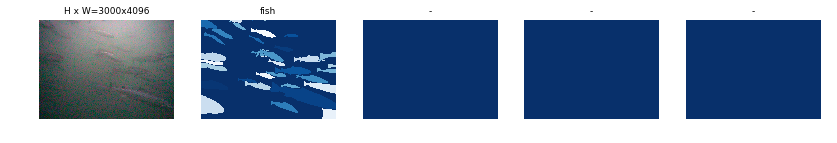

In [13]:
# Load and display random samples# Load  
image_ids = np.random.choice(dataset_train.image_ids, 4)
for image_id in image_ids:
    image = dataset_train.load_image(image_id)
    mask, class_ids = dataset_train.load_mask(image_id)
    visualize.display_top_masks(image, mask, class_ids, dataset_train.class_names)

## Configuration

In [14]:
image_size = 512
rpn_anchor_template = (1, 2, 4, 8, 16) # anchor sizes in pixels
rpn_anchor_scales = tuple(i * (image_size // 16) for i in rpn_anchor_template)

class FishConfig(Config):
    """Configuration for training on the shapes dataset.
    """
    NAME = "shapes"

    # Train on 1 GPU and 2 images per GPU. Put multiple images on each
    # GPU if the images are small. Batch size is 2 (GPUs * images/GPU).
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

    # Number of classes (including background)
    NUM_CLASSES = 1 + 1  # background + 3 shapes (triangles, circles, and squares)

    # Use smaller images for faster training. 
    IMAGE_MAX_DIM = image_size
    IMAGE_MIN_DIM = image_size
    
    # Use smaller anchors because our image and objects are small
    RPN_ANCHOR_SCALES = rpn_anchor_scales

    # Aim to allow ROI sampling to pick 33% positive ROIs.
    TRAIN_ROIS_PER_IMAGE = 32

    STEPS_PER_EPOCH = 400

    VALIDATION_STEPS = STEPS_PER_EPOCH / 20
    
config = FishConfig()
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_MAX_DIM                  512
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  512
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [512 512   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE                     [28, 28]
MAX_GT_INSTANCES               100
MEAN_PIXEL                     [123.7 116.8 103.9]
MI

## Model

In [15]:
model = modellib.MaskRCNN(mode="training", config=config, model_dir=MODEL_DIR)

In [16]:
inititalize_weights_with = "last"  # imagenet, coco, or last

if inititalize_weights_with == "imagenet":
    model.load_weights(model.get_imagenet_weights(), by_name=True)
    
elif inititalize_weights_with == "coco":
    model.load_weights(COCO_MODEL_PATH, by_name=True,
                       exclude=["mrcnn_class_logits", "mrcnn_bbox_fc", 
                                "mrcnn_bbox", "mrcnn_mask"])
    
elif inititalize_weights_with == "last":
    # Load the last model you trained and continue training
    model.load_weights(model.find_last()[1], by_name=True)

## Training

In [ ]:
model.train(dataset_train, dataset_validate, 
            learning_rate=config.LEARNING_RATE / 10,
            epochs=100, # starts from the previous epoch, so only 1 additional is trained 
            layers="all")


Starting at epoch 50. LR=0.0001

Checkpoint Path: /root/data/models/erko/mask_rcnn_instance_segmentation/logs/shapes20180826T1257/mask_rcnn_shapes_{epoch:04d}.h5
Selecting layers to train
conv1                  (Conv2D)
bn_conv1               (BatchNorm)
res2a_branch2a         (Conv2D)
bn2a_branch2a          (BatchNorm)
res2a_branch2b         (Conv2D)
bn2a_branch2b          (BatchNorm)
res2a_branch2c         (Conv2D)
res2a_branch1          (Conv2D)
bn2a_branch2c          (BatchNorm)
bn2a_branch1           (BatchNorm)
res2b_branch2a         (Conv2D)
bn2b_branch2a          (BatchNorm)
res2b_branch2b         (Conv2D)
bn2b_branch2b          (BatchNorm)
res2b_branch2c         (Conv2D)
bn2b_branch2c          (BatchNorm)
res2c_branch2a         (Conv2D)
bn2c_branch2a          (BatchNorm)
res2c_branch2b         (Conv2D)
bn2c_branch2b          (BatchNorm)
res2c_branch2c         (Conv2D)
bn2c_branch2c          (BatchNorm)
res3a_branch2a         (Conv2D)
bn3a_branch2a          (BatchNorm)
res3a_b

/usr/local/lib/python3.5/dist-packages/tensorflow/python/ops/gradients_impl.py:108: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.5/dist-packages/keras/engine/training_generator.py:46: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the`keras.utils.Sequence class.
  UserWarning('Using a generator with `use_multiprocessing=True`'


Epoch 51/100
400/400 [==============================] - 536s 1s/step - loss: 0.9873 - rpn_class_loss: 0.0775 - rpn_bbox_loss: 0.2424 - mrcnn_class_loss: 0.2288 - mrcnn_bbox_loss: 0.1747 - mrcnn_mask_loss: 0.2638 - val_loss: 1.3405 - val_rpn_class_loss: 0.1128 - val_rpn_bbox_loss: 0.4008 - val_mrcnn_class_loss: 0.2703 - val_mrcnn_bbox_loss: 0.2571 - val_mrcnn_mask_loss: 0.2994
Epoch 52/100
400/400 [==============================] - 316s 790ms/step - loss: 0.9950 - rpn_class_loss: 0.0782 - rpn_bbox_loss: 0.2416 - mrcnn_class_loss: 0.2334 - mrcnn_bbox_loss: 0.1754 - mrcnn_mask_loss: 0.2665 - val_loss: 1.4802 - val_rpn_class_loss: 0.1243 - val_rpn_bbox_loss: 0.5409 - val_mrcnn_class_loss: 0.2852 - val_mrcnn_bbox_loss: 0.2508 - val_mrcnn_mask_loss: 0.2791
Epoch 53/100
400/400 [==============================] - 435s 1s/step - loss: 1.0122 - rpn_class_loss: 0.0811 - rpn_bbox_loss: 0.2517 - mrcnn_class_loss: 0.2392 - mrcnn_bbox_loss: 0.1781 - mrcnn_mask_loss: 0.2621 - val_loss: 1.2225 - val_rp

Epoch 73/100
400/400 [==============================] - 401s 1s/step - loss: 0.9074 - rpn_class_loss: 0.0697 - rpn_bbox_loss: 0.2145 - mrcnn_class_loss: 0.2107 - mrcnn_bbox_loss: 0.1558 - mrcnn_mask_loss: 0.2567 - val_loss: 1.2652 - val_rpn_class_loss: 0.1076 - val_rpn_bbox_loss: 0.3648 - val_mrcnn_class_loss: 0.2607 - val_mrcnn_bbox_loss: 0.2398 - val_mrcnn_mask_loss: 0.2923
Epoch 74/100
400/400 [==============================] - 424s 1s/step - loss: 0.8876 - rpn_class_loss: 0.0665 - rpn_bbox_loss: 0.2047 - mrcnn_class_loss: 0.2031 - mrcnn_bbox_loss: 0.1538 - mrcnn_mask_loss: 0.2597 - val_loss: 1.2305 - val_rpn_class_loss: 0.1300 - val_rpn_bbox_loss: 0.3386 - val_mrcnn_class_loss: 0.2708 - val_mrcnn_bbox_loss: 0.2097 - val_mrcnn_mask_loss: 0.2815
Epoch 75/100
400/400 [==============================] - 425s 1s/step - loss: 0.8831 - rpn_class_loss: 0.0650 - rpn_bbox_loss: 0.2056 - mrcnn_class_loss: 0.2093 - mrcnn_bbox_loss: 0.1484 - mrcnn_mask_loss: 0.2548 - val_loss: 1.2941 - val_rpn_c

## Detection

### 1 - Inference config

In [17]:
class InferenceConfig(FishConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

inference_config = InferenceConfig()

# Recreate the model in inference mode
model = modellib.MaskRCNN(mode="inference", 
                          config=inference_config,
                          model_dir=MODEL_DIR)

# Get path to saved weights
# Either set a specific path or find last trained weights
# model_path = os.path.join(ROOT_DIR, ".h5 file name here")
print(model.find_last()[1])
model_path = model.find_last()[1]

# Load trained weights (fill in path to trained weights here)
assert model_path != "", "Provide path to trained weights"
print("Loading weights from ", model_path)
model.load_weights(model_path, by_name=True)

/root/data/models/erko/mask_rcnn_instance_segmentation/logs/shapes20180826T1257/mask_rcnn_shapes_0100.h5
Loading weights from  /root/data/models/erko/mask_rcnn_instance_segmentation/logs/shapes20180826T1257/mask_rcnn_shapes_0100.h5


### Test on random image from test set

original_image           shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
image_meta               shape: (14,)                 min:    0.00000  max: 4096.00000  float64
gt_class_id              shape: (43,)                 min:    1.00000  max:    1.00000  int32
gt_bbox                  shape: (43, 4)               min:    0.00000  max:  512.00000  int32
gt_mask                  shape: (512, 512, 43)        min:    0.00000  max:    1.00000  bool


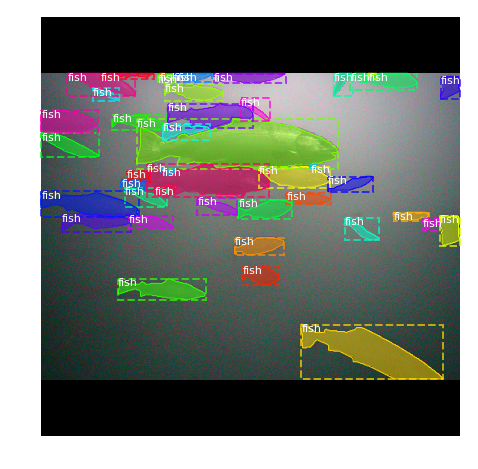

Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  148.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32


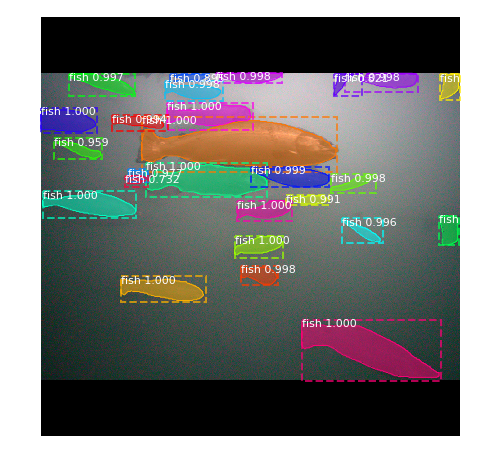

In [18]:
image_id = random.choice(dataset_validate.image_ids)
original_image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(dataset_validate, inference_config, 
                           image_id, use_mini_mask=False)

log("original_image", original_image)
log("image_meta", image_meta)
log("gt_class_id", gt_class_id)
log("gt_bbox", gt_bbox)
log("gt_mask", gt_mask)

visualize.display_instances(original_image, gt_bbox, gt_mask, gt_class_id, 
                            dataset_validate.class_names, figsize=(8, 8))

results = model.detect([original_image], verbose=1)

r = results[0]
visualize.display_instances(original_image, r['rois'], r['masks'], r['class_ids'], 
                            dataset_validate.class_names, r['scores'], ax=get_ax())

## Evaluation

In [21]:
predictions =\
extra_utils.compute_multiple_per_class_precision(model, inference_config, dataset_validate, iou_threshold=0.5)
complete_predictions = []

for shape in predictions:
    complete_predictions += predictions[shape]
    print("{} ({}): {}".format(shape, len(predictions[shape]), np.mean(predictions[shape])))

print("--------")
print("average: {}".format(np.mean(complete_predictions)))

fish (118): 0.6376008295035115
--------
average: 0.6376008295035115


## Testing

In [32]:
image_ids = dataset_validate.image_ids

In [33]:
image_id = image_ids[0]

In [34]:
image_id

0

In [35]:
image, _, gt_class_id, gt_bbox, gt_mask =\
            modellib.load_image_gt(dataset_validate, inference_config,
                                image_id, use_mini_mask=False)

In [38]:
import matplotlib.pyplot as plt

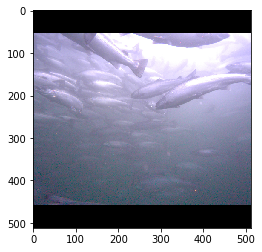

In [39]:
plt.imshow(image)

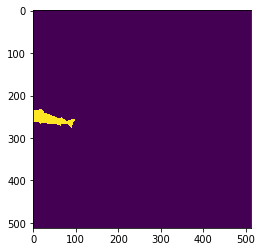

In [58]:
plt.imshow(gt_mask[..., 0])

In [51]:
results = model.detect([image], verbose=0)

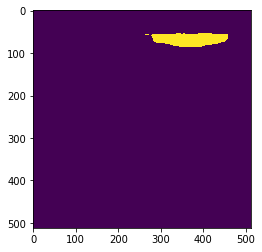

In [61]:
plt.imshow(results[0]['masks'][..., 2])